In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [2]:
# Download the dataset
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
print(data.shape)
data.head()

(4998, 141)


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
# last column is the target
# 0 = anomaly, 1 = normal
TARGET = 140
features = data.drop(TARGET, axis=1)
target = data[TARGET]
x_train, x_test, y_train, y_test = train_test_split(
features, target, test_size=0.2, stratify=target
)

In [4]:
# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]


In [5]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [8]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout

class AutoEncoder(Model):
    """
    Parameters
    ----------
    output_units: int
        Number of output units
    code_size: int
        Number of units in bottleneck
    """
    def __init__(self, output_units, code_size=8):
        super().__init__()
        self.encoder = Sequential([
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(code_size, activation='relu')
        ])
        self.decoder = Sequential([
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(output_units, activation='sigmoid')
        ])

    def call(self, inputs):  # Move this method to the class level
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

# Assuming x_train_scaled and x_test_scaled are preprocessed appropriately
model = AutoEncoder(output_units=x_train_scaled.shape[1])
model.compile(loss='msle', metrics=['mse'], optimizer='adam')
history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0113 - mse: 0.0257 - val_loss: 0.0132 - val_mse: 0.0307
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0109 - mse: 0.0247 - val_loss: 0.0128 - val_mse: 0.0299
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0103 - mse: 0.0233 - val_loss: 0.0124 - val_mse: 0.0289
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092 - mse: 0.0209 - val_loss: 0.0123 - val_mse: 0.0286
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0081 - mse: 0.0183 - val_loss: 0.0123 - val_mse: 0.0284
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070 - mse: 0.0157 - val_loss: 0.0121 - val_mse: 0.0278
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062 - mse: 0.0138 - val_loss: 0.0119 - val_mse: 0.0275
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0056 - mse: 0.0125 - val_loss: 0.0114 - val_mse: 0.0263
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0051 - mse: 0.0114 - 

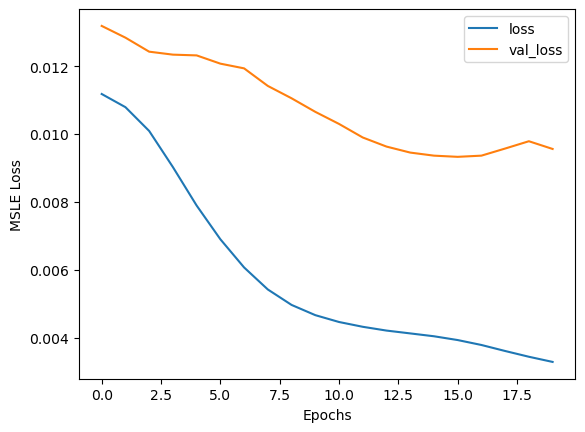

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [16]:
def find_threshold(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    # Calculate losses of individual instances
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
    
    # Threshold for anomaly scores
    threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())
    return threshold

def find_threshold_method_two(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
    
    threshold_2 = np.percentile(reconstruction_errors, 95)
    return threshold_2

def get_predictions(model, x_test_scaled, threshold):
    predictions = model.predict(x_test_scaled)
    # Calculate losses of individual instances
    errors = tf.keras.losses.msle(predictions, x_test_scaled)
    # 0 = anomaly, 1 = normal
    anomaly_mask = pd.Series(errors.numpy()) > threshold
    preds = anomaly_mask.map(lambda x: 0.0 if x else 1.0)
    return preds

In [17]:
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")
threshold_2 = find_threshold_method_two(model, x_train_scaled)
print(f"Threshold method two: {threshold_2}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold method one: 0.007097086173043495
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
Threshold method two: 0.009210172124533657


In [18]:
preds = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step


0.945

In [22]:
 !pip install -U keras-tuner

In [23]:
import kerastuner as kt
class AutoEncoderTuner(Model):
    
    def __init__(self, hp, output_units, code_size=8):
        super().__init__()
        dense_1_units = hp.Int('dense_1_units', min_value=16, max_value=72, step=4)
        dense_2_units = hp.Int('dense_2_units', min_value=16, max_value=72, step=4)
        dense_3_units = hp.Int('dense_3_units', min_value=16, max_value=72, step=4)
        dense_4_units = hp.Int('dense_4_units', min_value=16, max_value=72, step=4)
        dense_5_units = hp.Int('dense_5_units', min_value=16, max_value=72, step=4)
        dense_6_units = hp.Int('dense_6_units', min_value=16, max_value=72, step=4)
        
        self.encoder = Sequential([
            Dense(dense_1_units, activation='relu'),
            Dropout(0.1),
            Dense(dense_2_units, activation='relu'),
            Dropout(0.1),
            Dense(dense_3_units, activation='relu'),
            Dropout(0.1),
            Dense(code_size, activation='relu')
        ])
        
        self.decoder = Sequential([
            Dense(dense_4_units, activation='relu'),
            Dropout(0.1),
            Dense(dense_5_units, activation='relu'),
            Dropout(0.1),
            Dense(dense_6_units, activation='relu'),
            Dropout(0.1),
            Dense(output_units, activation='sigmoid')
        ])
        def call(self, inputs):
            encoded = self.encoder(inputs)
            decoded = self.decoder(encoded)
            return decoded
        def build_model(hp):
            model = AutoEncoderTuner(hp, 140)
            hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
            model.compile(
                loss='msle',
                optimizer=Adam(learning_rate=hp_learning_rate),
            )
            return model


ModuleNotFoundError: No module named 'kerastuner'

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='autoencoder',
    project_name='tuning_autoencoder6'
)
tuner.search(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)


In [ ]:
hparams = [f'dense_{i}_units' for i in range(1,7)] + ['learning_rate']
best_hyperparams = tuner.get_best_hyperparameters()
for hps in hparams:
    print(f"{hps}: {best_hyperparams[0][hps]}")

In [ ]:
best_model = tuner.get_best_models()[0]
best_model.compile(loss='msle', optimizer=Adam(0.001))
best_model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

In [ ]:
threshold_ = find_threshold(best_model, x_train_scaled)
preds_ = get_predictions(best_model, x_test_scaled, threshold_)
accuracy_score(preds_, y_test)